In [1]:
#!pip install cloudant

In [2]:
#!pip install h2o

In [3]:
#!pip install scikit-learn --upgrade

In [4]:
#!pip install lightgbm --upgrade

In [5]:
#!pip install xgboost --upgrade

In [6]:
#!pip install imblearn --upgrade

In [7]:
#!pip install holidays

In [8]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
from datetime import timedelta
import holidays

from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Definição das variáveis de conexão:

rodrigo = {'user': "",
           'password': "",
           'account': "",
           'db_name': ""
           }

In [10]:
# Funcao para carregar os dados do banco de dados NoSQL Cloudant
def obter_dados(user, password, account, db_name):

    client = Cloudant(user, password, account=account, connect=True, auto_renew=True)

    db = client[db_name]

    response = db.all_docs(limit=20000, include_docs=True)

    docs = []
    for r in response["rows"]:
        docs.append(r['doc'])

    return docs

# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    print("Linhas do dataset até o momento:")
    print(data.shape)

    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("\nLinhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('\nÓtimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def fe(df, treino=True):

    if treino:
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')

        # Buscando os dias de feriados em SP no periodo
        sp_holidays = holidays.CountryHoliday('BR', prov=None, state='SP')
        sp_holidays[df['Tempo'].min(): df['Tempo'].max()]

        # Cria uma coluna de feriado
        #df['feriado'] = df['Tempo'].isin(sp_holidays).astype(int)

        # Removendo colunas unicas
        data = df.drop(['Tempo', 'LAT', 'LONG', 'Movimentação','Estação','_id', '_rev', 'row'], axis = 1)

        # Verificar os registros duplicados
        verify_dup_rows(data)

        # Removendo registros duplicados
        data = data.drop_duplicates().reset_index(drop=True)
    
    else:
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')
        
        # Removendo colunas unicas
        data = df.drop(['Tempo', 'LAT', 'LONG', 'Movimentação', 'Estação'], axis = 1)

    return data

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['Estação'])

    return df    

In [11]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL do Walter:
train_walter = pd.DataFrame(data=obter_dados(walter['user'], walter['password'], walter['account'], walter['db_name']))
print(train_walter.shape)
train_walter.head()

(15545, 17)


,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,01ad2da675f70d124acfe65acd00bbb7,1-440d9157bc05c0d49d7a80d4e4704691,2018-6-16,Luz,-23.5365,-46.6332,124909,86,54,37,17,6,12,31,15,REABASTECER,10966
1,01ad2da675f70d124acfe65acd023786,1-78c9d076126486a5b48c4b8ea3a9dda2,2018-9-5,Luz,-23.5365,-46.6332,125689,86,25,21,19,43,13,30,32,NORMAL,11045
2,01ad2da675f70d124acfe65acd053c63,1-50fca8a067246c52b150477ebc347722,2019-3-4,Luz,-23.5365,-46.6332,124910,43,11,24,32,33,14,23,21,NORMAL,11224
3,01ad2da675f70d124acfe65acd0693bd,1-3e0475d6843032ca4e3150ea24c3486c,2019-5-3,Luz,-23.5365,-46.6332,127059,86,7,21,32,12,37,40,27,NORMAL,11283
4,01ad2da675f70d124acfe65acd07a3ee,1-01db4b5752a4c809e6419b3e9f26b92c,2019-7-15,Luz,-23.5365,-46.6332,126558,86,35,11,32,19,8,3,25,NORMAL,11355


In [12]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL do Rodrigo:
train_rodrigo = pd.DataFrame(data=obter_dados(rodrigo['user'], rodrigo['password'], rodrigo['account'], rodrigo['db_name']))
print(train_rodrigo.shape)
train_rodrigo.head()

(17827, 17)


,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,01ad2da675f70d124acfe65acd01dab1,1-f7574b928d29d6e5001425ce9ca89218,2018-8-18,Luz,-23.5365,-46.6332,125065,86,11,12,24,25,10,15,17,NORMAL,11028
1,01ad2da675f70d124acfe65acd022669,1-d80039ae3de6035727a8f1156418e350,2018-9-2,Luz,-23.5365,-46.6332,124100,30,51,42,24,13,24,43,1,NORMAL,11042
2,01ad2da675f70d124acfe65acd047ea0,1-950cad7c11e47539c146b56193a2ab0a,2019-1-16,Luz,-23.5365,-46.6332,124034,86,14,24,42,37,22,23,33,NORMAL,11176
3,01ad2da675f70d124acfe65acd0b4cc4,1-896395b34f3ca616c82c9d3bfd344463,2018-2-17,Ana Rosa,-23.5813,-46.6383,66283,77,36,65,28,25,33,30,3,NORMAL,11567
4,01ad2da675f70d124acfe65acd0d5842,1-c82ec74abfcae1c44dfbb896b4d5dbe1,2018-5-8,Ana Rosa,-23.5813,-46.6383,67321,66,57,53,9,8,22,8,23,NORMAL,11648


In [13]:
# Concatenando as bases de dados:
train = pd.concat([train_walter, train_rodrigo], ignore_index=True)

In [14]:
# Feature Engineering
treino = preenche_missing(train)    
treino = fe(treino, True) 

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print(treino.shape)

print('\n')

treino.head(10)

Linhas do dataset até o momento:
(33372, 9)

Linhas duplicadas até o momento:
(18370, 9)

Ótimo! Não há mais valores faltantes neste dataset.
(15002, 9)




,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,86,54,37,17,6,12,31,15,REABASTECER
1,86,25,21,19,43,13,30,32,NORMAL
2,43,11,24,32,33,14,23,21,NORMAL
3,86,7,21,32,12,37,40,27,NORMAL
4,86,35,11,32,19,8,3,25,NORMAL
5,28,15,51,7,43,18,5,33,NORMAL
6,27,58,35,22,32,29,29,4,REABASTECER
7,60,12,65,43,23,15,20,43,NORMAL
8,25,12,24,33,18,27,35,14,NORMAL
9,31,17,26,17,20,35,43,24,NORMAL


In [15]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 9 columns):
Original_473    15002 non-null int64
Original_269    15002 non-null int64
Zero            15002 non-null int64
Maçã-Verde      15002 non-null int64
Tangerina       15002 non-null int64
Citrus          15002 non-null int64
Açaí-Guaraná    15002 non-null int64
Pêssego         15002 non-null int64
TARGET          15002 non-null object
dtypes: int64(8), object(1)
memory usage: 1.0+ MB


,TARGET,%
NORMAL,10130,67.524
REABASTECER,4872,32.476


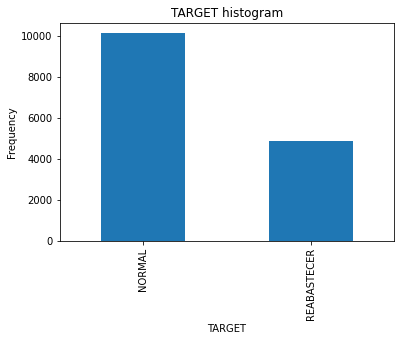

In [16]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [17]:
# Selecionando feature target
y = treino['TARGET']

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

In [18]:
# Resolvendo problema de Overfitting utilizando o OverSampling

# Import dos módulos
from imblearn.over_sampling import SMOTE

# Aplicando a funcao SMOTE
# SMOTE eh um metodo de oversampling. Ele cria exemplos sinteticos da classe minoritaria ao inves de criar copias
sm = SMOTE(random_state=0)
_X, _y = sm.fit_sample(X, y)

Using TensorFlow backend.


In [19]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.94      0.71      0.81      2039
 REABASTECER       0.76      0.95      0.85      2013

    accuracy                           0.83      4052
   macro avg       0.85      0.83      0.83      4052
weighted avg       0.85      0.83      0.83      4052

F1_macro   :  0.8268304203128829
F1_micro   :  0.8292201382033564
F1_weighted:  0.8266998895037395
F1_none    :  [0.8064877  0.84717314]


In [20]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_lr = LogisticRegression().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lr.predict(X_valid)

# Salvando o score
lr_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.62      0.63      0.63      2039
 REABASTECER       0.62      0.62      0.62      2013

    accuracy                           0.62      4052
   macro avg       0.62      0.62      0.62      4052
weighted avg       0.62      0.62      0.62      4052

F1_macro   :  0.6223718872707391
F1_micro   :  0.6224086870681145
F1_weighted:  0.6223958071390331
F1_none    :  [0.62609971 0.61864407]


In [21]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_knn = KNeighborsClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_knn.predict(X_valid)

# Salvando o score
knn_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.79      0.68      0.73      2039
 REABASTECER       0.72      0.82      0.77      2013

    accuracy                           0.75      4052
   macro avg       0.76      0.75      0.75      4052
weighted avg       0.76      0.75      0.75      4052

F1_macro   :  0.7489261233415047
F1_micro   :  0.75
F1_weighted:  0.7488207618580297
F1_none    :  [0.73250594 0.76534631]


In [22]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.79      0.77      0.78      2039
 REABASTECER       0.77      0.79      0.78      2013

    accuracy                           0.78      4052
   macro avg       0.78      0.78      0.78      4052
weighted avg       0.78      0.78      0.78      4052

F1_macro   :  0.782073245939283
F1_micro   :  0.7820829220138203
F1_weighted:  0.7820639282378766
F1_none    :  [0.78062112 0.78352537]


In [23]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.96      0.71      0.82      2039
 REABASTECER       0.77      0.97      0.86      2013

    accuracy                           0.84      4052
   macro avg       0.86      0.84      0.84      4052
weighted avg       0.86      0.84      0.84      4052

F1_macro   :  0.835902517911973
F1_micro   :  0.8383514313919053
F1_weighted:  0.835773888113027
F1_none    :  [0.81585606 0.85594898]


In [24]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.89      0.74      0.81      2039
 REABASTECER       0.77      0.91      0.84      2013

    accuracy                           0.82      4052
   macro avg       0.83      0.82      0.82      4052
weighted avg       0.83      0.82      0.82      4052

F1_macro   :  0.8209534714927913
F1_micro   :  0.8220631786771965
F1_weighted:  0.8208630251392033
F1_none    :  [0.80685776 0.83504919]


In [25]:
# Prepara a lista de resultados
metricas = [(gbc_score),(lr_score),(knn_score),(dtc_score),(rfc_score),(xgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'LR', 'KNN', 'DTC', 'RFC', 'XGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.826700
LR,0.622396
KNN,0.748821
DTC,0.782064
RFC,0.835774
XGB,0.820863


# AUTOML com H20

In [26]:
# Importando as bibliotecas
import h2o
from h2o.automl import H2OAutoML

# Inicializando o cluster
h2o.init()
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 days 18 hours 21 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.53 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,19 days 18 hours 21 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.53 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [27]:
# Importando os datasets   
df_treino = h2o.H2OFrame(treino)

# Convertendo a coluna target em fator
df_treino['TARGET'] = df_treino['TARGET'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
df_treino.head()

Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
86,54,37,17,6,12,31,15,REABASTECER
86,25,21,19,43,13,30,32,NORMAL
43,11,24,32,33,14,23,21,NORMAL
86,7,21,32,12,37,40,27,NORMAL
86,35,11,32,19,8,3,25,NORMAL
28,15,51,7,43,18,5,33,NORMAL
27,58,35,22,32,29,29,4,REABASTECER
60,12,65,43,23,15,20,43,NORMAL
25,12,24,33,18,27,35,14,NORMAL
31,17,26,17,20,35,43,24,NORMAL


# Treinamento sem balanceamento

In [29]:
# Indicando as colunas preditoras e a target
X = df_treino.drop(['TARGET'], axis = 1).columns
y = 'TARGET'

# Executa o AutoML para 20 modelos
aml = H2OAutoML(max_models=20, seed=133, balance_classes=False, verbosity='info')
aml.train(x=X, y=y, training_frame=df_treino)

AutoML progress: |
17:07:05.953: Project: AutoML_20200906_170705953
17:07:05.954: Setting stopping tolerance adaptively based on the training frame: 0.008164421532650366
17:07:05.954: Build control seed: 133
17:07:05.954: training frame: Frame key: automl_training_py_1_sid_93a1    cols: 9    rows: 15002  chunks: 1    size: 123088  checksum: -384917795878080
17:07:05.954: validation frame: NULL
17:07:05.954: leaderboard frame: NULL
17:07:05.954: blending frame: NULL
17:07:05.954: response column: TARGET
17:07:05.954: fold column: null
17:07:05.955: weights column: null
17:07:05.955: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
17:07:05.956: AutoML job created: 2020.09.06 17:07:05.953
17:07:05.962: AutoML build started: 2020.09.06 17:07:05.962
17:07:05.963:

In [30]:
# AutoML Leaderboard
lb = aml.leaderboard

# Exibir as colunas do resultado dos modelos
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20200906_170705,0.845556,0.428668,0.612211,0.163517,0.387385,0.150067
GBM_4_AutoML_20200906_170705,0.845547,0.410018,0.610082,0.1601,0.378846,0.143524
GBM_2_AutoML_20200906_170705,0.844646,0.398883,0.610794,0.159504,0.372861,0.139026
XGBoost_grid__1_AutoML_20200906_170705_model_2,0.843522,0.392592,0.603879,0.159382,0.373,0.139129
DRF_1_AutoML_20200906_170705,0.843405,0.3896,0.606851,0.161971,0.370939,0.137596
XRT_1_AutoML_20200906_170705,0.843334,0.391076,0.608707,0.160902,0.370298,0.137121
GBM_grid__1_AutoML_20200906_170705_model_2,0.843262,0.396544,0.606943,0.159834,0.375338,0.140878
StackedEnsemble_BestOfFamily_AutoML_20200906_170705,0.843128,0.406605,0.608493,0.159546,0.377096,0.142201
GBM_grid__1_AutoML_20200906_170705_model_1,0.843126,0.393339,0.608741,0.160302,0.374282,0.140087
StackedEnsemble_AllModels_AutoML_20200906_170705,0.842769,0.400199,0.606025,0.158942,0.374813,0.140485


In [31]:
# Detalhes do melhor modelo
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20200906_170705


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0735617677847337
RMSE: 0.27122272726439
LogLoss: 0.24662766261416458
Mean Per-Class Error: 0.08210668939257637
AUC: 0.9732858917812283
AUCPR: 0.9388489304318548
Gini: 0.9465717835624565

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049648710659572: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,9357.0,773.0,0.0763,(773.0/10130.0)
1,REABASTECER,475.0,4397.0,0.0975,(475.0/4872.0)
2,Total,9832.0,5170.0,0.0832,(1248.0/15002.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.504965,0.875722,193.0
1,max f2,0.379826,0.919876,243.0
2,max f0point5,0.598425,0.881167,154.0
3,max accuracy,0.510401,0.917078,191.0
4,max precision,0.981505,1.000000,0.0
5,max recall,0.162830,1.000000,320.0
6,max specificity,0.981505,1.000000,0.0
7,max absolute_mcc,0.504965,0.814095,193.0
8,max min_per_class_accuracy,0.490596,0.915025,198.0
9,max mean_per_class_accuracy,0.459063,0.917893,209.0



Gains/Lift Table: Avg response rate: 32,48 %, avg score: 32,35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010065,0.931026,3.079228,3.079228,1.000000,0.950631,1.000000,0.950631,0.030993,0.030993,207.922824,207.922824,0.030993
1,2,0.020064,0.907987,3.079228,3.079228,1.000000,0.918673,1.000000,0.934705,0.030788,0.061782,207.922824,207.922824,0.061782
2,3,0.030063,0.888014,3.017644,3.058746,0.980000,0.897070,0.993348,0.922188,0.030172,0.091954,201.764368,205.874557,0.091658
3,4,0.040061,0.873725,3.038172,3.053611,0.986667,0.879795,0.991681,0.911608,0.030378,0.122332,203.817187,205.361070,0.121838
4,5,0.050060,0.860004,3.038172,3.050527,0.986667,0.867380,0.990679,0.902774,0.030378,0.152709,203.817187,205.052705,0.152018
5,6,0.100053,0.800101,2.976587,3.013582,0.966667,0.830116,0.978681,0.866469,0.148810,0.301519,197.658730,201.358180,0.298360
6,7,0.150047,0.745228,2.898580,2.975265,0.941333,0.771897,0.966237,0.834959,0.144910,0.446429,189.858019,197.526496,0.438926
7,8,0.200040,0.689083,2.775411,2.925318,0.901333,0.716642,0.950017,0.805390,0.138752,0.585181,177.541106,192.531813,0.570373
8,9,0.300027,0.566677,2.377164,2.742641,0.772000,0.630901,0.890691,0.747240,0.237685,0.822865,137.716420,174.264075,0.774297
9,10,0.400013,0.413944,1.367177,2.398832,0.444000,0.493324,0.779037,0.683771,0.136700,0.959565,36.717734,139.883220,0.828667




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1500671055359692
RMSE: 0.38738495780808163
LogLoss: 0.4286679895871762
Mean Per-Class Error: 0.1635168912511732
AUC: 0.8455562903923867
AUCPR: 0.6122105858059051
Gini: 0.6911125807847733

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12409998642073737: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,6892.0,3238.0,0.3196,(3238.0/10130.0)
1,REABASTECER,36.0,4836.0,0.0074,(36.0/4872.0)
2,Total,6928.0,8074.0,0.2182,(3274.0/15002.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.124100,0.747103,325.0
1,max f2,0.101655,0.877882,330.0
2,max f0point5,0.173781,0.651104,312.0
3,max accuracy,0.173781,0.781896,312.0
4,max precision,0.983126,1.000000,0.0
5,max recall,0.025975,1.000000,371.0
6,max specificity,0.983126,1.000000,0.0
7,max absolute_mcc,0.124100,0.632126,325.0
8,max min_per_class_accuracy,0.423179,0.762883,227.0
9,max mean_per_class_accuracy,0.124100,0.836483,325.0



Gains/Lift Table: Avg response rate: 32,48 %, avg score: 32,26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010065,0.926568,1.855694,1.855694,0.602649,0.949928,0.602649,0.949928,0.018678,0.018678,85.569384,85.569384,0.012755
1,2,0.020064,0.905485,1.744896,1.800479,0.566667,0.916124,0.584718,0.933082,0.017447,0.036125,74.489600,80.047897,0.023785
2,3,0.030063,0.882556,2.093875,1.898061,0.680000,0.894192,0.616408,0.920147,0.020936,0.057061,109.387521,89.806087,0.039983
3,4,0.040061,0.864947,2.052819,1.936686,0.666667,0.873672,0.628952,0.908548,0.020525,0.077586,105.281883,93.668598,0.055572
4,5,0.050060,0.849587,1.827009,1.914780,0.593333,0.856981,0.621838,0.898248,0.018268,0.095854,82.700876,91.477975,0.067818
5,6,0.100053,0.782817,1.884488,1.899644,0.612000,0.814686,0.616922,0.856495,0.094212,0.190066,88.448768,89.964381,0.133304
6,7,0.150047,0.720903,1.872171,1.890490,0.608000,0.751500,0.613949,0.821512,0.093596,0.283662,87.217077,89.049020,0.197877
7,8,0.200040,0.663431,1.896805,1.892068,0.616000,0.692261,0.614462,0.789210,0.094828,0.378489,89.680460,89.206827,0.264274
8,9,0.300027,0.552301,1.866012,1.883385,0.606000,0.608697,0.611642,0.729052,0.186576,0.565066,86.601232,88.338488,0.392509
9,10,0.400013,0.433786,1.837273,1.871859,0.596667,0.494674,0.607899,0.670468,0.183703,0.748768,83.727285,87.185880,0.516488




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7823632,0.006265704,0.7724092,0.7800733,0.7863333,0.7876667,0.78533334
1,auc,0.84563005,0.0039864825,0.8397437,0.8443207,0.84737396,0.8461994,0.85051256
2,aucpr,0.61371624,0.016190916,0.60776645,0.59937984,0.60237485,0.63898706,0.62007296
3,err,0.21763684,0.006265704,0.2275908,0.21992669,0.21366666,0.21233334,0.21466666
4,err_count,653.0,18.907671,683.0,660.0,641.0,637.0,644.0
5,f0point5,0.6511964,0.008946672,0.642214,0.6430999,0.65565974,0.6636049,0.65140367
6,f1,0.7475203,0.0073822704,0.73961115,0.7413793,0.7506807,0.7578867,0.74804384
7,f2,0.8773215,0.0042810007,0.8718318,0.87511563,0.8779112,0.8833954,0.87835354
8,lift_top_group,1.8188937,0.47667453,1.9756418,1.5269157,1.2307693,2.4900398,1.8711019
9,logloss,0.42866728,0.00765879,0.4395932,0.4285858,0.43179005,0.42367768,0.41968963



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-09-06 17:07:07,1.954 sec,0.0,0.500000,0.693147,0.500000,0.324757,1.000000,0.675243
1,,2020-09-06 17:07:08,2.276 sec,5.0,0.365578,0.426426,0.894319,0.754371,2.877971,0.206173
2,,2020-09-06 17:07:08,2.332 sec,10.0,0.338822,0.361935,0.915239,0.802345,2.977267,0.188642
3,,2020-09-06 17:07:08,2.625 sec,15.0,0.320059,0.323318,0.934837,0.845631,2.956875,0.149447
4,,2020-09-06 17:07:08,2.683 sec,20.0,0.307502,0.301029,0.947135,0.874737,2.997659,0.127050
5,,2020-09-06 17:07:08,2.766 sec,25.0,0.294687,0.280106,0.957849,0.901332,3.058836,0.113652
6,,2020-09-06 17:07:08,2.865 sec,30.0,0.284234,0.264620,0.965431,0.919178,3.079228,0.098520
7,,2020-09-06 17:07:08,2.936 sec,35.0,0.272447,0.248360,0.972585,0.937020,3.079228,0.085922
8,,2020-09-06 17:07:08,2.988 sec,36.0,0.271223,0.246628,0.973286,0.938849,3.079228,0.083189



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Açaí-Guaraná,2512.670898,1.000000,0.138294
1,Original_269,2481.042969,0.987413,0.136553
2,Pêssego,2475.451172,0.985187,0.136245
3,Tangerina,2408.939209,0.958717,0.132585
4,Original_473,2240.924316,0.891850,0.123337
5,Maçã-Verde,2167.191406,0.862505,0.119279
6,Zero,1998.348999,0.795309,0.109986
7,Citrus,1884.480713,0.749991,0.103719


# Treinamento com balanceamento

In [32]:
# Indicando as colunas preditoras e a target
X = df_treino.drop(['TARGET'], axis = 1).columns
y = 'TARGET'

# Executa o AutoML para 20 modelos
aml2 = H2OAutoML(max_models=20, seed=133, balance_classes=True, verbosity='info')
aml2.train(x=X, y=y, training_frame=df_treino)

AutoML progress: |
18:12:21.705: Project: AutoML_20200906_181221705
18:12:21.705: Setting stopping tolerance adaptively based on the training frame: 0.008164421532650366
18:12:21.705: Build control seed: 133
18:12:21.705: training frame: Frame key: automl_training_py_1_sid_93a1    cols: 9    rows: 15002  chunks: 1    size: 123088  checksum: -384917795878080
18:12:21.705: validation frame: NULL
18:12:21.705: leaderboard frame: NULL
18:12:21.705: blending frame: NULL
18:12:21.705: response column: TARGET
18:12:21.705: fold column: null
18:12:21.705: weights column: null
18:12:21.706: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
18:12:21.706: AutoML job created: 2020.09.06 18:12:21.705
18:12:21.713: AutoML build started: 2020.09.06 18:12:21.712
18:12:21.713:

In [33]:
# AutoML Leaderboard
lb2 = aml2.leaderboard

# Exibir as colunas do resultado dos modelos
lb2.head(rows=lb2.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20200906_181221,0.845556,0.428668,0.612211,0.163517,0.387385,0.150067
GBM_1_AutoML_20200906_181221,0.844448,0.395834,0.609391,0.160009,0.372992,0.139123
StackedEnsemble_BestOfFamily_AutoML_20200906_181221,0.844371,0.413465,0.608735,0.158942,0.379128,0.143738
GBM_5_AutoML_20200906_181221,0.844319,0.395812,0.611703,0.159283,0.373921,0.139817
GBM_grid__1_AutoML_20200906_181221_model_2,0.844187,0.397752,0.611153,0.160025,0.377973,0.142864
GBM_grid__1_AutoML_20200906_181221_model_1,0.843995,0.398346,0.611924,0.160712,0.37856,0.143307
GBM_2_AutoML_20200906_181221,0.84371,0.396473,0.60497,0.159147,0.373943,0.139833
XGBoost_grid__1_AutoML_20200906_181221_model_2,0.843522,0.392592,0.603879,0.159382,0.373,0.139129
StackedEnsemble_AllModels_AutoML_20200906_181221,0.843343,0.405114,0.604738,0.158983,0.376349,0.141639
DRF_1_AutoML_20200906_181221,0.843269,0.404181,0.608786,0.160541,0.382212,0.146086


In [34]:
# Detalhes do melhor modelo
aml2.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20200906_181221


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0735617677847337
RMSE: 0.27122272726439
LogLoss: 0.24662766261416458
Mean Per-Class Error: 0.08210668939257637
AUC: 0.9732858917812283
AUCPR: 0.9388489304318548
Gini: 0.9465717835624565

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049648710659572: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,9357.0,773.0,0.0763,(773.0/10130.0)
1,REABASTECER,475.0,4397.0,0.0975,(475.0/4872.0)
2,Total,9832.0,5170.0,0.0832,(1248.0/15002.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.504965,0.875722,193.0
1,max f2,0.379826,0.919876,243.0
2,max f0point5,0.598425,0.881167,154.0
3,max accuracy,0.510401,0.917078,191.0
4,max precision,0.981505,1.000000,0.0
5,max recall,0.162830,1.000000,320.0
6,max specificity,0.981505,1.000000,0.0
7,max absolute_mcc,0.504965,0.814095,193.0
8,max min_per_class_accuracy,0.490596,0.915025,198.0
9,max mean_per_class_accuracy,0.459063,0.917893,209.0



Gains/Lift Table: Avg response rate: 32,48 %, avg score: 32,35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010065,0.931026,3.079228,3.079228,1.000000,0.950631,1.000000,0.950631,0.030993,0.030993,207.922824,207.922824,0.030993
1,2,0.020064,0.907987,3.079228,3.079228,1.000000,0.918673,1.000000,0.934705,0.030788,0.061782,207.922824,207.922824,0.061782
2,3,0.030063,0.888014,3.017644,3.058746,0.980000,0.897070,0.993348,0.922188,0.030172,0.091954,201.764368,205.874557,0.091658
3,4,0.040061,0.873725,3.038172,3.053611,0.986667,0.879795,0.991681,0.911608,0.030378,0.122332,203.817187,205.361070,0.121838
4,5,0.050060,0.860004,3.038172,3.050527,0.986667,0.867380,0.990679,0.902774,0.030378,0.152709,203.817187,205.052705,0.152018
5,6,0.100053,0.800101,2.976587,3.013582,0.966667,0.830116,0.978681,0.866469,0.148810,0.301519,197.658730,201.358180,0.298360
6,7,0.150047,0.745228,2.898580,2.975265,0.941333,0.771897,0.966237,0.834959,0.144910,0.446429,189.858019,197.526496,0.438926
7,8,0.200040,0.689083,2.775411,2.925318,0.901333,0.716642,0.950017,0.805390,0.138752,0.585181,177.541106,192.531813,0.570373
8,9,0.300027,0.566677,2.377164,2.742641,0.772000,0.630901,0.890691,0.747240,0.237685,0.822865,137.716420,174.264075,0.774297
9,10,0.400013,0.413944,1.367177,2.398832,0.444000,0.493324,0.779037,0.683771,0.136700,0.959565,36.717734,139.883220,0.828667




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1500671055359692
RMSE: 0.38738495780808163
LogLoss: 0.4286679895871762
Mean Per-Class Error: 0.1635168912511732
AUC: 0.8455562903923867
AUCPR: 0.6122105858059051
Gini: 0.6911125807847733

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12409998642073737: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,6892.0,3238.0,0.3196,(3238.0/10130.0)
1,REABASTECER,36.0,4836.0,0.0074,(36.0/4872.0)
2,Total,6928.0,8074.0,0.2182,(3274.0/15002.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.124100,0.747103,325.0
1,max f2,0.101655,0.877882,330.0
2,max f0point5,0.173781,0.651104,312.0
3,max accuracy,0.173781,0.781896,312.0
4,max precision,0.983126,1.000000,0.0
5,max recall,0.025975,1.000000,371.0
6,max specificity,0.983126,1.000000,0.0
7,max absolute_mcc,0.124100,0.632126,325.0
8,max min_per_class_accuracy,0.423179,0.762883,227.0
9,max mean_per_class_accuracy,0.124100,0.836483,325.0



Gains/Lift Table: Avg response rate: 32,48 %, avg score: 32,26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010065,0.926568,1.855694,1.855694,0.602649,0.949928,0.602649,0.949928,0.018678,0.018678,85.569384,85.569384,0.012755
1,2,0.020064,0.905485,1.744896,1.800479,0.566667,0.916124,0.584718,0.933082,0.017447,0.036125,74.489600,80.047897,0.023785
2,3,0.030063,0.882556,2.093875,1.898061,0.680000,0.894192,0.616408,0.920147,0.020936,0.057061,109.387521,89.806087,0.039983
3,4,0.040061,0.864947,2.052819,1.936686,0.666667,0.873672,0.628952,0.908548,0.020525,0.077586,105.281883,93.668598,0.055572
4,5,0.050060,0.849587,1.827009,1.914780,0.593333,0.856981,0.621838,0.898248,0.018268,0.095854,82.700876,91.477975,0.067818
5,6,0.100053,0.782817,1.884488,1.899644,0.612000,0.814686,0.616922,0.856495,0.094212,0.190066,88.448768,89.964381,0.133304
6,7,0.150047,0.720903,1.872171,1.890490,0.608000,0.751500,0.613949,0.821512,0.093596,0.283662,87.217077,89.049020,0.197877
7,8,0.200040,0.663431,1.896805,1.892068,0.616000,0.692261,0.614462,0.789210,0.094828,0.378489,89.680460,89.206827,0.264274
8,9,0.300027,0.552301,1.866012,1.883385,0.606000,0.608697,0.611642,0.729052,0.186576,0.565066,86.601232,88.338488,0.392509
9,10,0.400013,0.433786,1.837273,1.871859,0.596667,0.494674,0.607899,0.670468,0.183703,0.748768,83.727285,87.185880,0.516488




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7823632,0.006265704,0.7724092,0.7800733,0.7863333,0.7876667,0.78533334
1,auc,0.84563005,0.0039864825,0.8397437,0.8443207,0.84737396,0.8461994,0.85051256
2,aucpr,0.61371624,0.016190916,0.60776645,0.59937984,0.60237485,0.63898706,0.62007296
3,err,0.21763684,0.006265704,0.2275908,0.21992669,0.21366666,0.21233334,0.21466666
4,err_count,653.0,18.907671,683.0,660.0,641.0,637.0,644.0
5,f0point5,0.6511964,0.008946672,0.642214,0.6430999,0.65565974,0.6636049,0.65140367
6,f1,0.7475203,0.0073822704,0.73961115,0.7413793,0.7506807,0.7578867,0.74804384
7,f2,0.8773215,0.0042810007,0.8718318,0.87511563,0.8779112,0.8833954,0.87835354
8,lift_top_group,1.8188937,0.47667453,1.9756418,1.5269157,1.2307693,2.4900398,1.8711019
9,logloss,0.42866728,0.00765879,0.4395932,0.4285858,0.43179005,0.42367768,0.41968963



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-09-06 18:12:23,2.006 sec,0.0,0.500000,0.693147,0.500000,0.324757,1.000000,0.675243
1,,2020-09-06 18:12:24,2.430 sec,5.0,0.365578,0.426426,0.894319,0.754371,2.877971,0.206173
2,,2020-09-06 18:12:24,2.504 sec,10.0,0.338822,0.361935,0.915239,0.802345,2.977267,0.188642
3,,2020-09-06 18:12:24,2.584 sec,15.0,0.320059,0.323318,0.934837,0.845631,2.956875,0.149447
4,,2020-09-06 18:12:24,2.802 sec,20.0,0.307502,0.301029,0.947135,0.874737,2.997659,0.127050
5,,2020-09-06 18:12:24,2.869 sec,25.0,0.294687,0.280106,0.957849,0.901332,3.058836,0.113652
6,,2020-09-06 18:12:24,2.938 sec,30.0,0.284234,0.264620,0.965431,0.919178,3.079228,0.098520
7,,2020-09-06 18:12:24,2.989 sec,35.0,0.272447,0.248360,0.972585,0.937020,3.079228,0.085922
8,,2020-09-06 18:12:24,3.054 sec,36.0,0.271223,0.246628,0.973286,0.938849,3.079228,0.083189



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Açaí-Guaraná,2512.670898,1.000000,0.138294
1,Original_269,2481.042969,0.987413,0.136553
2,Pêssego,2475.451172,0.985187,0.136245
3,Tangerina,2408.939209,0.958717,0.132585
4,Original_473,2240.924316,0.891850,0.123337
5,Maçã-Verde,2167.191406,0.862505,0.119279
6,Zero,1998.348999,0.795309,0.109986
7,Citrus,1884.480713,0.749991,0.103719


# Realizando as previsoes em Teste

In [35]:
# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')

# Feature Engineering
teste = preenche_missing(test)    
teste = fe(teste, False)   

# Verificando as colunas com dados missing do dataset
check_missing(teste, display = 15)

print(teste.shape)

print('\n')


teste.head(10)


Ótimo! Não há mais valores faltantes neste dataset.
(984, 8)




,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5
5,57,35,55,43,31,9,22,43
6,45,33,50,39,25,5,16,39
7,34,28,41,39,22,43,13,34
8,22,24,31,35,18,40,8,29
9,9,16,26,33,13,38,4,24


In [36]:
df_teste = h2o.H2OFrame(teste)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
# Gerar as previsoes no dataset de teste
preds = aml.leader.predict(df_teste)

# Salvar o resultado no dataset de teste
result = preds[:,0]
df_teste['TARGET'] = result

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [38]:
df_teste.head()

Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
22,65,22,14,3,26,43,18,NORMAL
11,56,16,14,43,20,37,15,REABASTECER
86,51,8,11,41,20,35,12,REABASTECER
76,47,65,11,37,14,32,10,NORMAL
68,42,60,6,35,13,26,5,REABASTECER
57,35,55,43,31,9,22,43,NORMAL
45,33,50,39,25,5,16,39,NORMAL
34,28,41,39,22,43,13,34,NORMAL
22,24,31,35,18,40,8,29,NORMAL
9,16,26,33,13,38,4,24,REABASTECER


In [40]:
df_teste[df_teste['Original_473'] == 4]

Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
4,42,65,34,31,19,14,35,NORMAL
4,43,59,6,40,43,15,6,REABASTECER
4,39,58,23,20,27,40,22,REABASTECER
4,37,51,36,5,34,41,24,REABASTECER
4,6,23,37,35,19,26,43,REABASTECER
4,13,16,38,38,41,17,6,REABASTECER
4,56,34,9,21,2,23,27,REABASTECER
4,5,56,17,43,43,12,15,REABASTECER
4,38,7,23,43,7,34,25,REABASTECER
4,29,60,36,8,15,38,39,REABASTECER


In [39]:
# Gravar o arquivo de submissão ao Desafio
h2o.export_file(df_teste,'results.csv')

In [ ]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(df_teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(df_teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp